In [23]:
import pandas as pd
import os
import numpy as np
from PIL.Image import open
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, Lasso, Ridge
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import statsmodels.api as sm
import scipy.optimize as so

# 1.

Find the proper libraries/packages in your coding environment to perform the LASSO and Ridge regressions on the ORL face dataset (use the same gender labels created in your HW02).


## (a)

Select the lambda associated with the minimal MSE fit and compare the results with that of your stepwise regression in HW02.


### preparing dataset


In [3]:
try:
    path_ = os.getcwd()+'/ORL Faces'
except:
    print('Set path_ to your ORL Faces fold directory')

In [4]:
df = pd.DataFrame()

for people in range(1, 41):
    for order in range(1, 11):
        im = open(path_+'/'+str(people)+'_'+str(order)+'.png')
        ar = pd.DataFrame(np.mat(np.asarray(im)).flatten(), columns=[
                          r for r in range(1, 2577)], index=[(people-1)*10+order])
        df = pd.concat([df, ar], axis=0)
    # print(df)
df

,1,2,3,4,5,6,7,8,9,10,...,2567,2568,2569,2570,2571,2572,2573,2574,2575,2576
1,88,88,90,91,91,92,90,93,99,109,...,168,176,166,149,142,145,141,138,142,134
2,87,90,95,96,92,90,97,107,111,112,...,167,175,172,147,131,132,124,124,120,88
3,92,92,88,98,104,109,108,100,80,63,...,111,84,128,154,161,169,170,165,146,151
4,92,96,93,94,99,105,108,109,121,152,...,154,153,164,163,165,166,161,157,79,54
5,83,75,88,91,101,90,86,80,63,58,...,141,145,148,151,139,134,173,167,176,188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,124,124,125,123,124,125,123,124,123,122,...,57,34,63,37,37,37,38,39,38,40
397,128,128,128,128,129,128,129,127,127,127,...,96,92,90,90,91,91,91,91,92,93
398,122,123,124,124,123,123,122,126,130,126,...,68,24,57,41,37,36,37,38,40,38
399,120,119,121,119,120,121,122,117,111,100,...,146,137,134,101,26,77,95,95,92,90


In [5]:
gender = [0]*10 + [1]*10 + [1]*10 + [1]*10 + [1]*10 + [1]*10 + [1]*10 + [0]*10 + [1]*10 + [0]*10 + \
    [1]*10 + [1]*10 + [1]*10 + [1]*10 + [1]*10 + [1]*10 + [1]*10 + [1]*10 + [1]*10+[1]*10 + [1]*10 + \
    [1]*10 + [1]*10 + [1]*10 + [1]*10 + [1]*10 + [1]*10 + [1]*10 + [1]*10 + [1] * 10 + \
    [1]*10 + [0]*10 + [1]*10 + [1]*10 + [1] * 10 + \
    [1]*10 + [1]*10 + [1]*10 + [1]*10 + [1]*10

In [6]:
df['gender'] = gender
df.head()

,1,2,3,4,5,6,7,8,9,10,...,2568,2569,2570,2571,2572,2573,2574,2575,2576,gender
1,88,88,90,91,91,92,90,93,99,109,...,176,166,149,142,145,141,138,142,134,0
2,87,90,95,96,92,90,97,107,111,112,...,175,172,147,131,132,124,124,120,88,0
3,92,92,88,98,104,109,108,100,80,63,...,84,128,154,161,169,170,165,146,151,0
4,92,96,93,94,99,105,108,109,121,152,...,153,164,163,165,166,161,157,79,54,0
5,83,75,88,91,101,90,86,80,63,58,...,145,148,151,139,134,173,167,176,188,0


In [7]:
X = df.drop(['gender'], axis=1)
y = df['gender']

### Lasso


In [8]:
# spilt the data into training and testing datasets
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, train_size=0.7, random_state=322)

# lasso alpha range
alpha_range = np.logspace(-8, 2, 100, base=10)

In [9]:
from sklearn.model_selection import cross_val_score


model = Lasso(max_iter=50000)

mse_score = []
for alpha in alpha_range:
    model.set_params(alpha=alpha)
    score = -cross_val_score(model, (Xtrain), ytrain,
                             cv=5, scoring='neg_mean_squared_error')
    mse_score.append(np.mean(score))


best_alpha = alpha_range[np.argmin(mse_score)]
print('Best alpha:', best_alpha)

Best alpha: 0.298364724028334


Text(0, 0.5, 'mse')

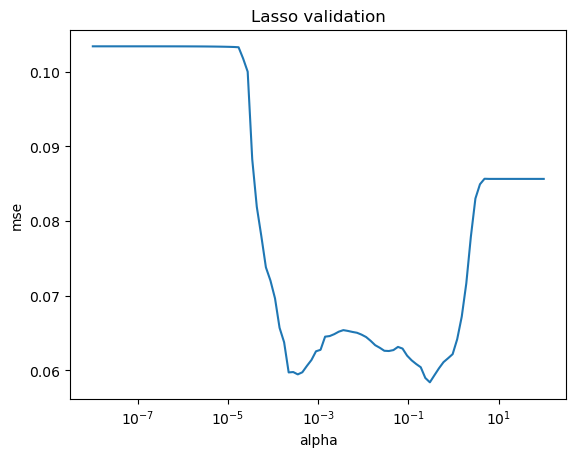

In [10]:
mse_score = pd.Series(mse_score, index=alpha_range)

fig, ax = plt.subplots()
mse_score.plot(title='Lasso validation', ax=ax)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('mse')

Lasso picked 118 variables and eliminated the other 2458 variables


Text(0, 0.5, 'pixel')

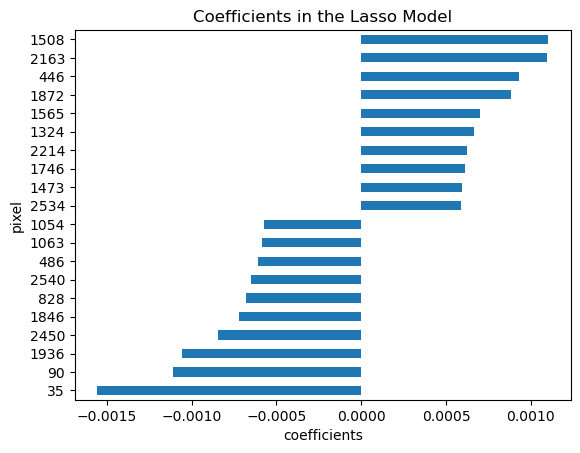

In [11]:
model.set_params(alpha=best_alpha).fit(Xtrain, ytrain)

coef = pd.Series(model.coef_, index=Xtrain.columns)
print("Lasso picked " + str(sum(coef != 0)) +
      " variables and eliminated the other " + str(sum(coef == 0)) + " variables")

imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

imp_coef.plot(kind="barh")
plt.title("Coefficients in the Lasso Model")
plt.xlabel('coefficients')
plt.ylabel('pixel')

### Ridge


In [12]:
# lasso alpha range
alpha_range2 = np.logspace(-3, 9, 100, base=10)

In [13]:
from sklearn.model_selection import cross_val_score


model_R = Ridge(max_iter=50000)

mse_score_R = []
coef_R = []
for alpha in alpha_range2:
    model_R.set_params(alpha=alpha)
    score = -cross_val_score(model_R, scale(Xtrain),
                             ytrain, cv=10, scoring='neg_mean_squared_error')
    mse_score_R.append(np.mean(score))
    model_R.fit(scale(Xtrain), ytrain)
    coef_R.append(model_R.coef_)


best_alpha2 = alpha_range2[np.argmin(mse_score_R)]
print('Best alpha:', best_alpha2)

Best alpha: 215.44346900318865


Text(0.5, 1.0, 'Ridge coefficients as a function of the regularization')

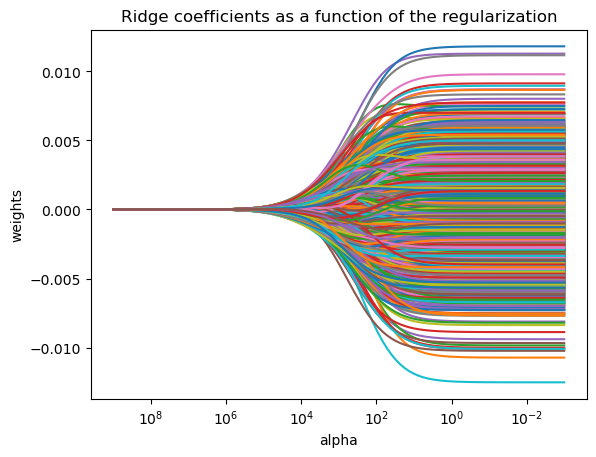

In [14]:
ax = plt.gca()
ax.plot(alpha_range2, coef_R)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')

Text(0, 0.5, 'mse')

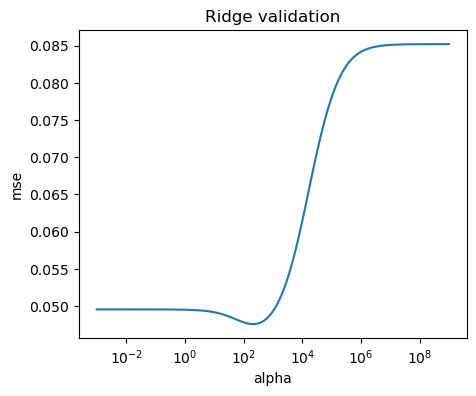

In [15]:
mse_score_R = pd.Series(mse_score_R, index=alpha_range2)

fig, ax = plt.subplots(figsize=(5, 4))
mse_score_R.plot(title='Ridge validation', ax=ax)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('mse')

Lasso picked 118 variables and eliminated the other 2458 variables


Text(0, 0.5, 'pixel')

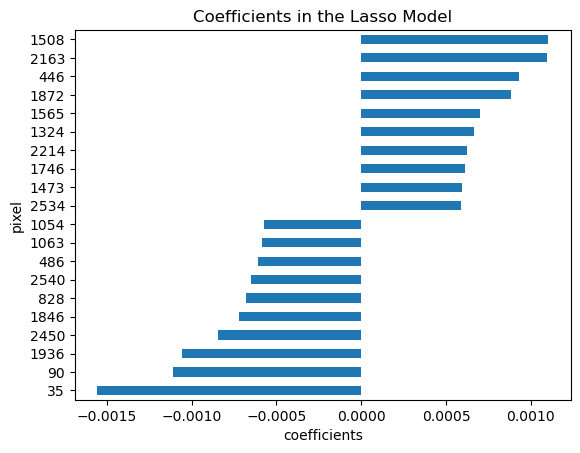

In [16]:
model_R.set_params(alpha=best_alpha2).fit(Xtrain, ytrain)

coef_R = pd.Series(model_R.coef_, index=Xtrain.columns)
print("Lasso picked " + str(sum(coef != 0)) +
      " variables and eliminated the other " + str(sum(coef == 0)) + " variables")

imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

imp_coef.plot(kind="barh")
plt.title("Coefficients in the Lasso Model")
plt.xlabel('coefficients')
plt.ylabel('pixel')

## (b)

Plot the chosen pixels from LASSO regression on a 46 × 56 canvas


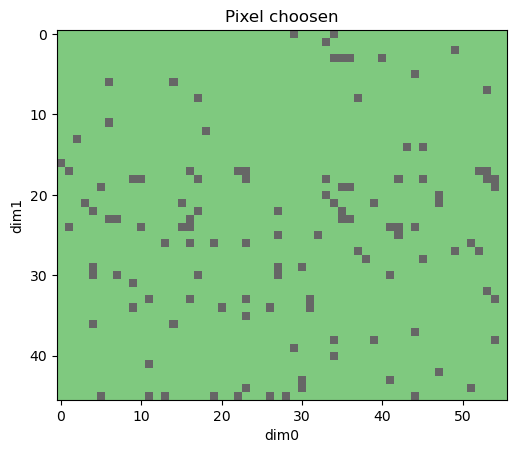

In [17]:
included = coef[coef != 0].index

# plot the choosen pixel on canvas
chosen_pixel = np.zeros((46, 56))
for pixel in included:
    chosen_pixel[(pixel-1)//56, (pixel-1) % 56] = 1

plt.imshow(chosen_pixel, cmap='Accent')
plt.title('Pixel choosen')
plt.xlabel('dim0')
plt.ylabel('dim1')
plt.show()

stepwise

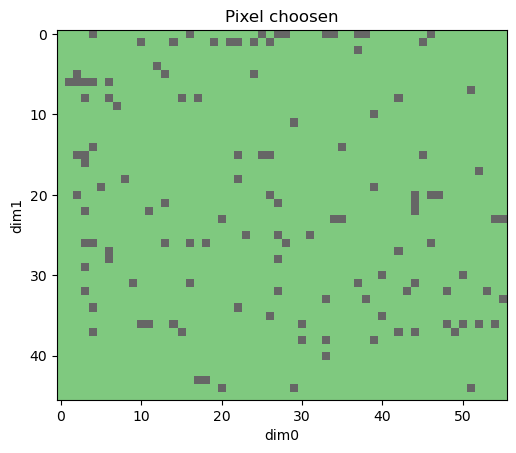

In [305]:
from IPython.display import Image

Image('output.png')

使用stepwise, lasso, ridge regrssion效果不同，其中stepwise應為最不準確的，因為在其演算法有變數排序放入model的問題
- 上圖為使用stepwise選擇出之重要pixel
- 上上圖為使用lasso選擇出之重要pi重要pixel

# 2.

The following table, provided by Dr. Philip Israelovich of the Federal Reserve Bank, gives the information on
capital, labor, and value added of the economics of transportation equipment. (Ashish Sen, and Muni
Srivastava, Regression Analysis)


## (a)

Consider the model
where the subscript 𝑡 indicates the year, 𝑉𝑡 is value added, 𝐾𝑡 is capital, 𝐿𝑡 is labor, and 𝜂𝑡 is the error term, with E[log(𝜂𝑡)] = 0 and V[log(𝜂𝑡)] a constant. Assuming the errors are independent across the years, estimate 𝛽1 and 𝛽2.


### load data


In [18]:
df2 = pd.read_excel('transport.xlsx')
df2

,Year,Capital,Labor,Value Added
0,72,1209188,1259142,11150.0
1,73,1330372,1371795,12853.6
2,74,1157371,1263084,10450.8
3,75,1070860,1118226,9318.3
4,76,1233475,1274345,12097.7
5,77,1355769,1369877,12844.8
6,78,1351667,1451595,13309.9
7,79,1326248,1328683,13402.3
8,80,1089545,1077207,8571.0
9,81,1111942,1056231,8739.7


### log transformation


$$log(V_t)=log(\alpha)+\beta_1 log(K_t)+\beta_2 log(L_t)+log(\eta_t)$$
$$y=constant+\beta_1 a_1+\beta_2 a_2+ErrorTerm$$


In [19]:
cols = ['logV_t', 'logK_t', 'logL_t', 'logEta_t']
df2.columns = cols
df2 = np.log(df2)

df2

,logV_t,logK_t,logL_t,logEta_t
0,4.276666,14.005460,14.045941,9.319195
1,4.290459,14.100969,14.131631,9.461379
2,4.304065,13.961662,14.049067,9.254434
3,4.317488,13.883973,13.927254,9.139735
4,4.330733,14.025346,14.057943,9.400771
5,4.343805,14.119879,14.130232,9.460694
6,4.356709,14.116849,14.188174,9.496263
7,4.369448,14.097864,14.099699,9.503182
8,4.382027,13.901271,13.889882,9.056140
9,4.394449,13.921619,13.870217,9.075631


### estimate


In [21]:
X = df2.drop(['logV_t', 'logEta_t'], axis=1)
X = sm.add_constant(X)  # constant term
y = df2['logV_t']

model_LR = sm.OLS(y, X).fit()
print(model_LR.summary())

                            OLS Regression Results                            
Dep. Variable:                 logV_t   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     13.07
Date:                Sun, 02 Apr 2023   Prob (F-statistic):           0.000971
Time:                        13:04:38   Log-Likelihood:                 30.948
No. Observations:                  15   AIC:                            -55.90
Df Residuals:                      12   BIC:                            -53.77
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5124      1.330      3.394      0.0

c:\Users\user\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [22]:
print(model_LR.params)

const     4.512379
logK_t    0.953282
logL_t   -0.963368
dtype: float64


## (b)

The model in (a) is said to be of the Cobb-Douglas form. It is easier to interpret if 𝛽1 + 𝛽2 = 1.
Estimate 𝛽1 and 𝛽2 under this constraint


In [39]:
def objective(beta, X, y):
    beta1, beta2 = beta
    error = y-beta1*X[:, 0]-beta2*X[:, 1]
    return np.sum(error**2)


constraint = [{'type': 'eq', 'fun': lambda beta: beta[0]+beta[1]-1}]


results = so.minimize(objective, [0.5, 0.5], args=(
    df2[['logK_t', 'logL_t']].values, df2['logV_t'].values), constraints=constraint)
print(f'beta1:{results.x[0]:.4f}\nbeta2:{results.x[1]:.4f}')

beta1:17.2211
beta2:-16.2211


# 3.

Implement a PCA function without using the available packages/libraries in R/Python. The input parameters
of this function are the data matrix 𝐗 and a Boolean flag “isCorrMX.” The Boolean flag allows users to choose
if the correlation matrix is used when set TRUE; otherwise, the covariance matrix would be decomposed. You
can start with the function of Spectral Decomposition or Singular Value Decomposition


## (a)

Necessary outputs are:

- the loading matrix;
- the eigenvalue value vector;
- the score matrix, i.e., the matrix of principal components; and
- the scree plot where eigenvalues are shown as bars and cumulative variance explained is drawn as a
  line (similar to the one on p. 36 of the slides DA04)


In [253]:
def pca(X, isCorrMX=True):
    
    # corrMX
    if isCorrMX:
        corr_cov = np.corrcoef(X, rowvar=False)
    else:
        corr_cov = np.cov(X, rowvar=False)

    # spectral decomposition
    eigenvalues, eigenvectors = np.linalg.eig(corr_cov)

    # sort eigenvalues in descending order and compute the explained variance
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    explained_variance = eigenvalues/np.sum(eigenvalues)

    # compute the loading matrix and score matrix
    loading_matrix = eigenvectors
    if isCorrMX:
        score_matrix = np.dot(X, eigenvectors)
    else:
        score_matrix = np.dot(X, eigenvectors)

    # generate the dcree plot
    cumvar = np.cumsum(explained_variance)
    fig, ax = plt.subplots()
    ax.bar(np.arange(1, len(explained_variance)+1), explained_variance,
           color='blue', label='Variance of principal component')
    ax.plot(np.arange(1, len(explained_variance)+1), cumvar,
            color='red', label='Cumulative percentage of variance explained')
    ax.set_xlabel('Principal component')
    ax.set_ylabel('Eigenvalue / Explained variance')
    ax.set_title('scree plot')
    plt.legend()
    plt.show()

    return loading_matrix, eigenvalues, eigenvectors, score_matrix, fig, cumvar

## (b)

Demonstrate your PCA function using the AutoMPG dataset. By comparing the results of “isCorrMX
== TRUE” and “isCorrMX == FALSE”, do you think PCA is scale-invariant?


### isCorrMX == False

In [268]:
cols = ['mpg', 'cylinders', 'displacement', 'horsepower',
        'weight', 'acceleration', 'model year', 'origin', 'car name']

c = pd.read_csv('auto-mpg.data.txt', header=None, sep='\s+', names=cols)

# deal with horsepower missing values
c = c[c['horsepower'] != '?']

# turn the horsepower type from object to float
c['horsepower'] = c['horsepower'].astype(float)

c.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


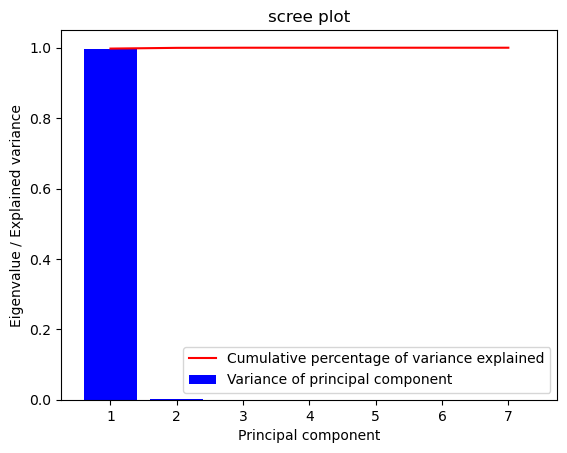

In [269]:
X = c.drop(['mpg', 'car name'], axis=1)
loading_matrix, eigenvalues, eigenvectors, score_matrix, fig, cumvar = pca(
    X, False)

score matrix


In [270]:
pd.DataFrame(score_matrix)

,0,1,2,3,4,5,6
0,3518.400107,95.975531,17.669803,-72.303008,19.132070,3.134085,-2.752764
1,3712.296580,67.673220,37.409578,-73.955615,21.520584,2.926148,-2.253842
2,3452.936763,71.360987,33.552072,-73.426484,20.197468,2.960058,-2.726435
3,3448.356612,84.274453,37.728027,-73.242467,21.052892,2.930053,-2.970374
4,3463.623063,91.028299,28.923657,-72.858792,18.625081,3.016707,-2.898828
...,...,...,...,...,...,...,...
387,2788.793664,181.290889,27.560073,-81.689135,20.122882,1.930333,-1.595181
388,2127.374929,152.719670,9.282407,-80.275545,27.761596,3.058074,-2.094952
389,2296.776095,126.704364,28.701280,-82.530814,17.479542,1.865370,-1.738544
390,2622.438897,182.474471,27.157986,-81.270024,22.809292,1.939251,-1.964691


loading matrix


In [271]:
pd.DataFrame(loading_matrix)

,0,1,2,3,4,5,6
0,0.001793,-0.013324,-0.007292,0.001428,-0.017168,0.285519,-0.958096
1,0.114341,-0.945778,-0.303257,-0.009210,0.010609,0.002347,0.016171
2,0.038967,-0.298248,0.948714,-0.043078,0.086440,-0.009425,-0.007422
3,0.992673,0.120753,-0.002453,0.001486,-0.003153,0.000120,0.000291
4,-0.001353,0.034826,-0.077003,0.059537,0.994496,0.003209,-0.016676
5,-0.001337,0.023852,-0.042816,-0.997250,0.055506,-0.000879,-0.002752
6,-0.000552,0.003243,0.012464,-0.001941,0.002660,0.958318,0.285394


Eigenvector


In [272]:
e_V = pd.DataFrame(eigenvectors)
e_V.index = X.columns

e_V.columns = ['e'+str(i) for i in range(1, (X.shape[1])+1)]
round(e_V, 2)

,e1,e2,e3,e4,e5,e6,e7
cylinders,0.00,-0.01,-0.01,0.00,-0.02,0.29,-0.96
displacement,0.11,-0.95,-0.30,-0.01,0.01,0.00,0.02
horsepower,0.04,-0.30,0.95,-0.04,0.09,-0.01,-0.01
weight,0.99,0.12,-0.00,0.00,-0.00,0.00,0.00
acceleration,-0.00,0.03,-0.08,0.06,0.99,0.00,-0.02
model year,-0.00,0.02,-0.04,-1.00,0.06,-0.00,-0.00
origin,-0.00,0.00,0.01,-0.00,0.00,0.96,0.29


Eigenvalues


In [273]:
e_VS = pd.DataFrame(eigenvalues, columns=['lambda'])
e_VS.index = [i for i in range(1, len(e_VS)+1)]
e_VS

,lambda
1,732151.674348
2,1513.972022
3,261.244860
4,10.972633
5,2.878749
6,0.378993
7,0.264153


### isCorrMX == True

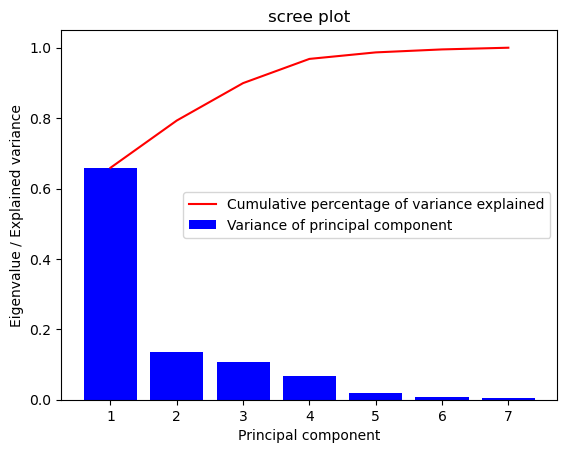

In [274]:
loading_matrix, eigenvalues, eigenvectors, score_matrix, fig, cumvar = pca(
    X, True)

score matrix


In [275]:
pd.DataFrame(score_matrix)

,0,1,2,3,4,5,6
0,-1694.207370,-776.198455,30.959471,1250.742712,-1239.938124,2371.521086,-441.108506
1,-1810.803319,-813.916551,36.060865,1325.048883,-1318.449435,2481.208727,-447.036744
2,-1678.870896,-760.260615,36.189207,1231.664092,-1225.765464,2310.690606,-422.023894
3,-1670.930230,-758.630276,35.357177,1228.955107,-1227.308783,2309.188551,-433.320749
4,-1673.005628,-762.360917,34.164817,1231.963290,-1227.262628,2327.182377,-436.447128
...,...,...,...,...,...,...,...
387,-1285.432065,-628.706236,35.057996,980.580965,-998.556591,1902.860496,-435.559193
388,-962.996858,-498.920072,31.659385,753.702911,-757.412467,1456.956905,-338.541742
389,-1069.667502,-526.151345,43.060328,811.487541,-825.270190,1555.144007,-343.871727
390,-1201.137577,-595.543080,33.765362,922.791516,-940.880857,1790.836188,-419.421744


loading matrix


In [276]:
pd.DataFrame(loading_matrix)

,0,1,2,3,4,5,6
0,-0.438118,-0.120214,0.025530,0.240871,0.700160,-0.194831,-0.454695
1,-0.453366,-0.107443,0.022196,0.159331,0.176287,-0.063710,0.849647
2,-0.437557,0.142440,0.178506,0.124582,-0.579393,-0.613608,-0.169288
3,-0.431946,-0.202775,-0.012594,0.335229,-0.348536,0.707768,-0.193274
4,0.297708,-0.482186,-0.559064,0.527333,-0.120916,-0.270696,0.018386
5,0.214733,-0.642498,0.731845,0.028882,-0.024231,-0.063132,0.009091
6,0.299563,0.517002,0.344505,0.713990,0.079480,0.057186,0.070128


Eigenvector


In [277]:
e_V = pd.DataFrame(eigenvectors)
e_V.index = X.columns

e_V.columns = ['e'+str(i) for i in range(1, (X.shape[1])+1)]
round(e_V, 2)

,e1,e2,e3,e4,e5,e6,e7
cylinders,-0.44,-0.12,0.03,0.24,0.70,-0.19,-0.45
displacement,-0.45,-0.11,0.02,0.16,0.18,-0.06,0.85
horsepower,-0.44,0.14,0.18,0.12,-0.58,-0.61,-0.17
weight,-0.43,-0.20,-0.01,0.34,-0.35,0.71,-0.19
acceleration,0.30,-0.48,-0.56,0.53,-0.12,-0.27,0.02
model year,0.21,-0.64,0.73,0.03,-0.02,-0.06,0.01
origin,0.30,0.52,0.34,0.71,0.08,0.06,0.07


Eigenvalues


In [278]:
e_VS = pd.DataFrame(eigenvalues, columns=['lambda'])
e_VS.index = [i for i in range(1, len(e_VS)+1)]
e_VS

,lambda
1,4.612059
2,0.940032
3,0.744165
4,0.481310
5,0.129569
6,0.059160
7,0.033705


透過以上的結果(使用correlation, covariance matrix的結果相異)可以判斷出pca is not scale-invariant

# 4.

Transpose the ORL face dataset to let 𝐗 be a 2576 × 400 data matrix. Apply PCA to 𝐗, using the PCA function
you created in EX3 above


## (a)

How many principal components are needed to explain 50%, 60%, 70%, 80%, and 90% of the total
variance?


In [292]:
df4 = df.drop(['gender'], axis=1).T.copy()
df4

,1,2,3,4,5,6,7,8,9,10,...,391,392,393,394,395,396,397,398,399,400
1,88,87,92,92,83,93,94,94,65,89,...,121,128,129,127,127,124,128,122,120,124
2,88,90,92,96,75,90,96,90,79,89,...,122,128,127,125,127,124,128,123,119,125
3,90,95,88,93,88,97,99,93,88,92,...,121,128,127,126,128,125,128,124,121,125
4,91,96,98,94,91,97,98,90,100,96,...,121,128,127,126,129,123,128,124,119,125
5,91,92,104,99,101,92,96,98,86,87,...,123,128,127,126,128,124,129,123,120,124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2572,145,132,169,166,134,186,182,190,189,169,...,35,90,90,36,88,37,91,36,77,36
2573,141,124,170,161,173,182,177,183,191,175,...,37,90,91,36,89,38,91,37,95,33
2574,138,124,165,157,167,100,144,190,182,190,...,37,89,91,37,88,39,91,38,95,33
2575,142,120,146,79,176,56,74,189,169,185,...,36,90,91,36,88,38,92,40,92,34


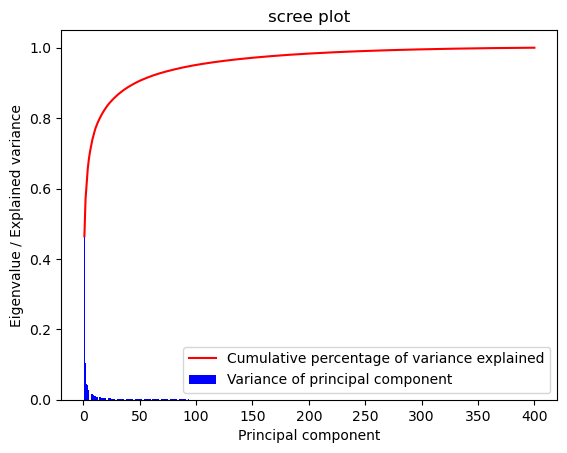

In [293]:
loading_matrix, eigenvalues, eigenvectors, score_matrix, fig, cumvar = pca(
    df4, False)

In [294]:
cumvar = pd.DataFrame(cumvar, columns=['cumulative'])
cu = [0.5, 0.6, 0.7, 0.8, 0.9]

for percentage in cu:
    num = cumvar[cumvar['cumulative'] > percentage].index[0]
    print(
        f'needs {num} components to explain {percentage} of the total variance')

needs 1 components to explain 0.5 of the total variance
needs 2 components to explain 0.6 of the total variance
needs 5 components to explain 0.7 of the total variance
needs 14 components to explain 0.8 of the total variance
needs 46 components to explain 0.9 of the total variance


## (b)

Rescale the first principal component (PC) into the range of [0, 255]. Reshape the first PC (initially
an 2576 × 1 vector) into a 46 × 56 matrix. Plot an image from the 46 × 56 matrix using the rescaled PC
scores as the grayscale values


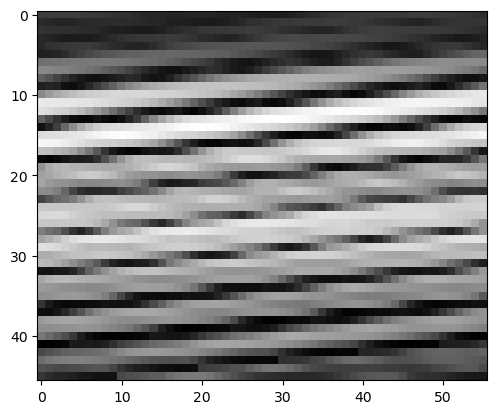

In [303]:
# rescale pc1 into the range of [0,255]
pc1=score_matrix[:,0]
pc1_rescale=(pc1-np.min(pc1))*255/(np.max(pc1)-np.min(pc1))

# reshape pc1 into 46*56 matrix
pc1_reshaped=pc1_rescale.reshape((46,56))

# plot
plt.imshow(pc1_reshaped,cmap='gray')
plt.show()